# Library

In [1]:
import numpy as np
import torch
import gpytorch
import argparse
import time
import pickle
import scipy.io as sio

from torch.distributions import Normal
import matplotlib.pyplot as plt
import random

import roslib
import rospy
import tf as tf_ros
from nav_msgs.msg import Odometry, Path
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
from geometry_msgs.msg import PoseStamped, PoseArray, Pose
import math
import cv2
import copy

import sys
sys.path.append('..')

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


## Check GPU

In [2]:
import torch
import numpy as np
import sys
sys.path.append('..')

from torchlib.utils import list_device,set_device

# S1: check GPU
#list_device()

# S2: default parameters
set_device(1)
np.set_printoptions(precision = 2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

Using Device 1 : TITAN Xp


# Set Arguments

In [3]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=300, help='size of mini batch')
parser.add_argument('--is_normalization', type=bool, default=True, help='whether do data normalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int, help='Input images will be resized to this for data argumentation.')
parser.add_argument('--output_dim', default=3, type=int, help='output dimention.')
parser.add_argument('--feat_dim', default=128, type=int, help='feature dimention.')
parser.add_argument('--model_dir', type=str, default='/notebooks/global_localization/kmeans_gps', help='rnn, gru, or lstm')

parser.add_argument('--test_dataset', type=str, default=[# '/notebooks/michigan_nn_data/2012_01_08',
                                                         # '/notebooks/michigan_nn_data/2012_01_15',
                                                         # '/notebooks/michigan_nn_data/2012_01_22',
                                                         # '/notebooks/michigan_nn_data/2012_02_02',
                                                         # '/notebooks/michigan_nn_data/2012_02_04',
                                                         # '/notebooks/michigan_nn_data/2012_02_05',
                                                         '/notebooks/michigan_nn_data/2012_02_12',
                                                         # '/notebooks/michigan_nn_data/2012_03_31',
                                                         '/notebooks/michigan_nn_data/2012_04_29',
                                                         '/notebooks/michigan_nn_data/2012_05_11',
                                                         '/notebooks/michigan_nn_data/2012_06_15',
                                                         '/notebooks/michigan_nn_data/2012_08_04',
                                                         # '/notebooks/michigan_nn_data/2012_09_28'])
                                                         '/notebooks/michigan_nn_data/2012_10_28',
                                                         '/notebooks/michigan_nn_data/2012_11_16',
                                                         '/notebooks/michigan_nn_data/2012_12_01'
                                                        ] )

parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/test'])
parser.add_argument('--norm_tensor', type=str, default = ['/notebooks/global_localization/norm_mean_std.pt'])

#parser.add_argument('--map_dataset', type=str, default='/home/kevin/data/michigan_gt/training')
parser.add_argument('--seed', default=1337, type=int)
parser.add_argument('--enable_ros', type=bool, default=False, help='put data into ros')
parser.add_argument('--num_gp', type=int, default=15, help='number of local gps')

sys.argv = ['']
args = parser.parse_args()

if args.enable_ros:
    rospy.init_node('global_localization_tf_broadcaster_cnn')

# Load Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tf.transformations as tf_tran
from tqdm import tqdm
#from PIL import Image
import numpy as np
import random

#
import gpytorch

import torch.nn as nn
import torch.optim as optim
from torchlib import resnet, vggnet, cnn_auxiliary
from torchlib.cnn_auxiliary import normalize, denormalize, denormalize_navie, get_relative_pose, translational_rotational_loss
from torchlib.utils import LocalizationDataset, display_loss, data2tensorboard
import time

transform = transforms.Compose([transforms.ToTensor()])
dataset = LocalizationDataset(dataset_dirs = args.test_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, get_pair = False, mode='evaluate')

if len(args.train_dataset)>7:
    [args.norm_mean, args.norm_std] = [torch.tensor(x) for x in dataset.get_norm()]
    torch.save([args.norm_mean, args.norm_std], *args.norm_tensor)
    print('Save norm and std:',*args.norm_tensor)
else:
    [args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)
    print('Load norm and std:',*args.norm_tensor)

    
dataloader = DataLoader(dataset, batch_size=args.batch_size, \
                        shuffle=False, num_workers=0, \
                        drop_last=False, pin_memory=True)

100%|██████████| 12683/12683 [00:16<00:00, 759.92it/s]


Load norm and std: /notebooks/global_localization/norm_mean_std.pt


# K-means

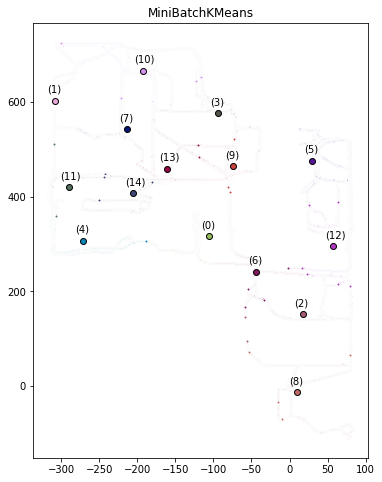

In [6]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin

centers = np.load(os.path.join(args.model_dir,'k-means_gp15.npy'))

def draw(X,centers,seed):
    num_gp = centers.shape[0]
    np.random.seed(seed)
    r = lambda: np.random.randint(0,255)
    colors = ['#%02X%02X%02X' % (r(),r(),r()) for _ in range(num_gp)]
    
    labels = pairwise_distances_argmin(X, centers)
    
    fig = plt.figure(figsize=(6, 8))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(num_gp):
        points_mask = labels == i
        center = centers[i]
        ax.plot(X[points_mask, 0], X[points_mask, 1], 'w',
                markerfacecolor=colors[i], marker='.')
        ax.plot(center[0], center[1], 'o', 
                markerfacecolor=colors[i], markeredgecolor='k', markersize=6)
        ax.annotate("(%s)" % i, xy=center, xytext=(-8, 8), textcoords='offset points')
    ax.set_title('MiniBatchKMeans')
    plt.show()
    
X = np.array(dataset.Targets)[:,:2]
draw(X,centers, args.seed)

# Define Model

In [7]:
from torchlib.model import Backbone, NN, GP#, GPNode_local
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import BernoulliLikelihood

class BasicTrainer:
    def __init__(self,norm_mean,norm_std):
        self.model = None
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
    def disable_requires_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
            
    def load_model(self, file_name = 'pretrained.pth', strict = True):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            # Part 1: backbone
            backbone_state_dict = self._from_old_model(state_dict,'backbone')
            print('Backbone parameters layer:',len(backbone_state_dict.keys()))
            self.model.backbone.load_state_dict(backbone_state_dict,strict = True)
            # Part 2: nn
            nn_state_dict = self._from_old_model(torch.load(os.path.join(args.model_dir, file_name)),'nn')
            print('NN parameters layer:',len(nn_state_dict.keys()))
            self.model.nn.load_state_dict(nn_state_dict,strict = strict)
        else:
            print('Parameters layer:',len(state_dict.keys()))
            # load file to model
            self.model.load_state_dict(state_dict,strict = strict)
        # Display model structure
        #print('Model Structure:')
        #for name, param in self.model.named_parameters():
        #    print(name, param.shape)
        print('Successfully loaded model...')
        print('Parameters layer:',len(self.model.state_dict().keys()))
    
    def _from_old_model(self, state_dict, select = 'backbone'):
        if select == 'backbone':
            for key in list(state_dict):
                if 'net.resnet.' in key:
                    state_dict[key.replace('net.resnet.','resnet.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        elif select == 'nn':
            for key in list(state_dict):
                if 'net.global_regressor.' in key:
                    state_dict[key.replace('net.global_regressor.','global_regressor.')] = state_dict.pop(key)
                elif 'net.global_context.' in key:
                    state_dict[key.replace('net.global_context.','global_context.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        return state_dict
    
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
        
    def show_require_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print (name, param.shape)

class GPNode_local(nn.Module):
    def __init__(self,inducing_points):
        super(GPNode_local,self).__init__()
        output_dim = inducing_points.shape[0] # 3-dim
        feat_dim = inducing_points.shape[-1]
        
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim) 
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output

class GPNode_global(nn.Module):
    def __init__(self,inducing_points,num_gp,p):
        super(GPNode_global,self).__init__()
        
        self.layer = nn.Sequential(
                    nn.Linear(128,128),
                    nn.ReLU(True),
                    nn.Dropout(p = p),
                    nn.Linear(128,128),
        )
        self.gp = GP(inducing_points,num_gp)
        self.likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=num_gp, num_classes=num_gp)

    def forward(self,input_data):
        input_data = self.layer(input_data)
        output = self.gp(input_data)
        return output

class Model(nn.Module):
    def __init__(self,num_gp,p=0.4):
        super().__init__()
        self.num_gp = num_gp

        # Part 1: basic NN
        self.backbone = Backbone()
        self.nn = NN()
        # Part 2: global GP
        inducing_points = torch.zeros(self.num_gp, 300, args.feat_dim) # num_grid x 300 x 128
        self.global_gp = GPNode_global(inducing_points,self.num_gp,p)
        
        # Part 3: local GPs
        self.local_gps = nn.ModuleList()
        for i in range(self.num_gp):
            inducing_points = torch.zeros(args.output_dim, 300, args.feat_dim)
            gp = GPNode_local(inducing_points)
            self.local_gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention  
        return feature_t, rot_pred
    '''
    def forward_gp(self, gp, trans_feat):
        trans_pred = gp(trans_feat)
        return trans_pred
    '''

In [158]:
class Trainer(BasicTrainer):
    def __init__(self, centers,norm_mean, norm_std,
                 regressor_context_rate = [0.0,0.0],
                 is_training=True, disable_rot_learning = True, 
                 train_global_gp = True, train_local_gps = True):
        
        super().__init__(norm_mean, norm_std)
        self.centers = centers
        self.model = Model(centers.shape[0]).cuda()
        self.disable_rot_learning = disable_rot_learning
        self.train_global_gp = train_global_gp
        self.train_local_gps = train_local_gps
        
        self.disable_requires_grad(self.model.backbone)
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
            #self.scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=self.optimizer, T_max = 80)
        else:
            self.disable_requires_grad(self.model)
            
    def _optimize(self,regressor_context_rate):
        optimizer = list()
        # Local GPs
        if self.train_local_gps:
            optimizer += [
                    {'params': self.model.local_gps.parameters(), \
                     'lr': args.learning_rate,'weight_decay':args.weight_decay}]            
        else:
            self.disable_requires_grad(self.model.local_gps)
            
        # Global GP
        if self.train_global_gp:
            optimizer += [{'params': self.model.global_gp.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.global_gp)
            
        # NN
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            self.disable_requires_grad(self.model.nn.global_regressor)
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            self.disable_requires_grad(self.model.nn.global_context)
            
        if self.disable_rot_learning and regressor_context_rate[1]!=0.0:
            print("Warning: Set 'disable_rot_learning' to False")
            self.disable_rot_learning = False
        
        if self.disable_rot_learning and regressor_context_rate[1]==0.0:
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc1_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc2_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc3_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.logits_r)
                
        return optimizer
    
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        start = time.time()
        
        label = pairwise_distances_argmin(y[:,:2],self.centers)
        label = torch.from_numpy(label).cuda()
            
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std) # input should be 7 dim
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        global_gp_loss = torch.tensor(0.).cuda()
        local_gps_loss = np.zeros(self.model.num_gp)
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        # Step 2-0: rotation
        if not self.disable_rot_learning:
            rot_loss = self._nn_loss(rot_pred,rot_target)
        
        # Step 2-1: global GP classification
        if self.train_global_gp:
            gp = self.model.global_gp # gp + likelihood
            num_data = min(len(dataloader)*args.batch_size,len(dataset)) # !!! not safe
            global_gp_loss = self._gp_loss(gp,num_data,trans_feat,label)
        
        # Step 2-2: local GPs regression
        if self.train_local_gps:
            num_batch_data = 0
            for i,gp in enumerate(self.model.local_gps):
                num_data = dis[i]
                label_mask = label == i
                sub_x = trans_feat[label_mask]
                sub_y = trans_target[label_mask]
                gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                local_gps_loss[i] = float(gp_loss)
                trans_loss += gp_loss * int(sub_y.shape[0])
                num_batch_data += int(sub_y.shape[0])
            trans_loss = trans_loss/num_batch_data
        
        # Step 2-3: rotation 
        if not self.disable_rot_learning:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss + args.lamda_weights * rot_loss
            else:
                total_loss = trans_loss + args.lamda_weights * rot_loss
        else:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss
            else:
                total_loss = trans_loss
            
        #Step 3: update
        if self.train_global_gp or self.train_local_gps:
            total_loss.backward()
            self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), float(global_gp_loss), local_gps_loss, batch_time
        
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        trans_pred = gp(trans_feat)
        #mll = gpytorch.mlls.VariationalELBO(gp.likelihood, gp.gp, 
        #                                    num_data=num_data).cuda()
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, 
                                            num_data=num_data).cuda()
        
        trans_loss = -1.*mll(trans_pred, trans_target)
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_classifier(self,x,y):
        label = pairwise_distances_argmin(y[:,:2],self.centers) # n x ,
        label = torch.from_numpy(label).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            gp = self.model.global_gp # gp + likelihood
            output = gp(trans_feat)
            output = gp.likelihood(output)
            pred = output.probs.mean(0).argmax(-1)
        return pred, label
    
    def eval_classifier_top2(self,x,y):
        label = pairwise_distances_argmin(y[:,:2],self.centers) # n x ,
        label = torch.from_numpy(label).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            gp = self.model.global_gp # gp + likelihood
            output = gp(trans_feat)
            output = gp.likelihood(output)
            pred_i = output.probs.mean(0)#.argmax(-1)
            pred_1 = pred_i.argsort(-1)[:,-3:][:,[2,1,0]][:,0]
            pred_2 = pred_i.argsort(-1)[:,-3:][:,[2,1,0]][:,1]
            prob_1 = pred_i[range(pred_i.shape[0]),pred_1]
            prob_2 = pred_i[range(pred_i.shape[0]),pred_2]
            
        return pred_1, prob_1, pred_2, prob_2
    
    def eval_forward(self,x,y,num_sample = 100, output_denormalize = True, label_from_gp = True):
        # Step 1: get data
        if not label_from_gp:
            label = pairwise_distances_argmin(y[:,:2],self.centers) # n x ,
        else:
            label,_ = self.eval_classifier(x.cpu(),y.cpu())
            
        x,y = x.cuda(),y.cuda()
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()
        
        for i,gp in enumerate(self.model.local_gps):
            label_mask = label == i
            sub_x = trans_feat[label_mask]
            sub_trans_pred = gp(sub_x)
            sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
            if args.is_normalization and output_denormalize:
                trans_pred[label_mask] = denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std)
                trans_mean[label_mask] = denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std)
                trans_var[label_mask] = sub_trans_var.mul(self.norm_std)
            else:
                trans_pred[label_mask] = sub_trans_pred
                trans_mean[label_mask] = sub_trans_mean
                trans_var[label_mask] = sub_trans_var
                    
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples
    
    def eval_forward_top2(self,x,y,num_sample = 100, output_denormalize = True):
        # Step 1: get data
        label_1, prob_1, label_2, prob_2 = self.eval_classifier_top2(x.cpu(),y.cpu())
        threshold = 0.8
        prob_1[prob_1>threshold] = 1
        prob_1[prob_1<=1-threshold] = 0
        prob_2[prob_2>threshold] = 1
        prob_2[prob_2<=1-threshold] = 0    
        
        x,y = x.cuda(),y.cuda()
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()
        
        for i,gp in enumerate(self.model.local_gps):
            label_mask = label_1 == i
            sub_x = trans_feat[label_mask]
            prob_weight = prob_1[label_mask].reshape(-1,1)
            sub_trans_pred = gp(sub_x)
            sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
            if args.is_normalization:
                trans_pred[label_mask] += denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std) * prob_weight
                trans_mean[label_mask] += denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std) * prob_weight
                trans_var[label_mask] += sub_trans_var.mul(self.norm_std) * prob_weight
            else:
                trans_pred[label_mask] += sub_trans_pred * prob_weight
                trans_mean[label_mask] += sub_trans_mean * prob_weight
                trans_var[label_mask] += sub_trans_var * prob_weight
        
        for i,gp in enumerate(self.model.local_gps):
            label_mask = label_2 == i
            sub_x = trans_feat[label_mask]
            prob_weight = prob_2[label_mask].reshape(-1,1)
            sub_trans_pred = gp(sub_x)
            sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
            if args.is_normalization and output_denormalize:
                trans_pred[label_mask] += denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std) * prob_weight
                trans_mean[label_mask] += denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std) * prob_weight
                trans_var[label_mask] += sub_trans_var.mul(self.norm_std) * prob_weight
            else:
                trans_pred[label_mask] += sub_trans_pred * prob_weight
                trans_mean[label_mask] += sub_trans_mean * prob_weight
                trans_var[label_mask] += sub_trans_var * prob_weight
        
        total_weight = (prob_1 + prob_2).reshape(-1,1)
        trans_pred /= total_weight
        trans_mean /= total_weight
        trans_var /= total_weight
                    
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples

trainer = Trainer(centers,args.norm_mean,args.norm_std,
                  is_training=False)

trainer.load_model('pretrained.pth')
trainer.show_require_grad()

Parameters layer: 509
Successfully loaded model...
Parameters layer: 509


# Classification

In [19]:
from torch.distributions import Normal
trainer.model.eval()

error_num = 0
total_num = 0
for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    pred, target = trainer.eval_classifier(x,y)
    acc = float(torch.sum(pred - target == 0))/float(target.shape[0])
    error_num += float(torch.sum(pred - target != 0))
    total_num += float(target.shape[0])
    if error_num >0:
        break
        pass
    
    if b % 10 == 0:
        print("%.2f" % acc,'-',float(torch.sum(pred - target != 0)),'/',float(target.shape[0]))
        
print("ACC: %.2f" % (1-(error_num/total_num)))
print('Total error number:', error_num)

1.00 - 0.0 / 300.0
ACC: 0.99
Total error number: 5.0


# `y` + local GP

In [13]:
trans_errors = []
rot_errors = []
uncertainties = []
pose_map = []

total_trans_error = 0.
total_rot_error = 0.

count = 0.

is_save_map = False
is_read_map = False

trans_preds = []
trans_gts = []

rot_preds = []
rot_gts = []

pred_uncertainties = []

pred_time = []

br = tf_ros.TransformBroadcaster()

GT_POSE_TOPIC = '/gt_pose'
BIRDVIEW_TOPIC_PUB = '/bird_view'
MAP_TOPIC_PUB = '/pose_map'
PARTICLES_PUB = '/particles'
NN_LOCALIZASION_PUB = '/nn_pose'
gt_pose_pub = rospy.Publisher(GT_POSE_TOPIC, Odometry, queue_size=1)
bird_view_pub = rospy.Publisher(BIRDVIEW_TOPIC_PUB, Image, queue_size=1)
map_pub = rospy.Publisher(MAP_TOPIC_PUB, Path, queue_size=1)
particles_pub = rospy.Publisher(PARTICLES_PUB, PoseArray, queue_size=1)
nn_pose_pub = rospy.Publisher(NN_LOCALIZASION_PUB, Odometry, queue_size=1)

trainer.model.eval()

for b, data in enumerate(dataloader, 0):
    start = time.time()
    x,y = data.values()
    trans_pred, rot_pred, trans_gt, rot_gt, samples = trainer.eval_forward(x,y,label_from_gp = False)
    
    # transform data
    trans_pred = trans_pred.cpu().numpy()
    rot_pred = rot_pred.cpu().numpy()
    trans_gt = trans_gt.cpu().numpy()
    rot_gt = rot_gt.cpu().numpy()
    
    end = time.time()
    
    if args.enable_ros:
        particles = PoseArray()
        particles.header.stamp = rospy.Time.now()
        particles.header.frame_id = 'world'
        for s in samples:
            pose = Pose()
            [pose.position.x, pose.position.y, pose.position.z] = s
            [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w] = rot_pred[0]
            particles.poses.append(pose)
        particles_pub.publish(particles)

        [px_pred, py_pred, pz_pred] = trans_pred[0]
        [qx_pred, qy_pred, qz_pred, qw_pred] = rot_pred[0]

        br.sendTransform((px_pred, py_pred, pz_pred),
                         (qx_pred, qy_pred, qz_pred, qw_pred), rospy.Time.now(),
                         "estimation", "world")

        [px_gt, py_gt, pz_gt] = trans_gt[0]
        [qx_gt, qy_gt, qz_gt, qw_gt] = rot_gt[0]

        br.sendTransform((px_gt, py_gt, pz_gt),
                         (qx_gt, qy_gt, qz_gt, qw_gt),
                         rospy.Time.now(), "gt", "world")

        timestamp = rospy.Time.now()

        nn_pose_msg = Odometry()
        nn_pose_msg.header.frame_id = 'world'
        nn_pose_msg.header.stamp = timestamp
        nn_pose_msg.child_frame_id = 'base_link'
        nn_pose_msg.pose.pose.position.x = px_pred
        nn_pose_msg.pose.pose.position.y = py_pred
        nn_pose_msg.pose.pose.position.z = pz_pred
        [nn_pose_msg.pose.pose.orientation.x, nn_pose_msg.pose.pose.orientation.y, nn_pose_msg.pose.pose.orientation.z, nn_pose_msg.pose.pose.orientation.w] = [qx_pred, qy_pred, qz_pred, qw_pred]

        conv = np.zeros((6,6), dtype=np.float32)
        [conv[0][0], conv[1][1], conv[2][2]] = trans_cov[0]
        nn_pose_msg.pose.covariance = conv.flatten().tolist()
        nn_pose_pub.publish(nn_pose_msg)

        bridge = CvBridge()

        bird_view_img_msg = bridge.cv2_to_imgmsg(np.asarray(x[0].cpu(), dtype=np.float32), encoding="passthrough")
        stamp_now = rospy.Time.now()
        bird_view_img_msg.header.stamp = stamp_now

        bird_view_pub.publish(bird_view_img_msg)

        rospy.sleep(.0)
        cv2.waitKey(0)

        count += 1
    else:
        count += y.shape[0]
    
    trans_preds += [x for x in trans_pred]
    rot_preds += [x for x in rot_pred]
    trans_gts += [x for x in trans_gt]
    rot_gts += [x for x in rot_gt]

    trans_error = np.sqrt(np.sum((trans_pred - trans_gt)**2,axis=1))
    rot_error_1 = np.arccos(np.sum(np.multiply(rot_pred,rot_gt),axis=1))/math.pi*180
    rot_error_2 = np.arccos(np.sum(np.multiply(rot_pred,-rot_gt),axis=1))/math.pi*180
    rot_error = np.minimum(rot_error_1,rot_error_2)

    trans_errors += [x for x in trans_error]
    rot_errors += [x for x in rot_error]

    total_trans_error += np.sum(trans_error)
    total_rot_error += np.sum(rot_error)
    
    display = 1

    if b % display == 0:
        print(
            "{}/{}, translation error = {:.3f}, rotation error = {:.3f}, time/batch = {:.3f}"
            .format(
             (b+1)*args.batch_size,
            len(dataloader)*args.batch_size,
            total_trans_error / count,
            total_rot_error / count,
            end - start))

300/92100, translation error = 2.713, rotation error = 2.763, time/batch = 0.945
600/92100, translation error = 6.527, rotation error = 3.388, time/batch = 0.794
900/92100, translation error = 7.164, rotation error = 3.357, time/batch = 0.796
1200/92100, translation error = 6.281, rotation error = 3.423, time/batch = 0.795
1500/92100, translation error = 5.669, rotation error = 3.531, time/batch = 0.792
1800/92100, translation error = 5.026, rotation error = 3.514, time/batch = 0.799
2100/92100, translation error = 4.827, rotation error = 3.635, time/batch = 0.804
2400/92100, translation error = 4.461, rotation error = 3.546, time/batch = 0.795
2700/92100, translation error = 4.266, rotation error = 3.670, time/batch = 0.799
3000/92100, translation error = 4.144, rotation error = 3.689, time/batch = 0.795
3300/92100, translation error = 3.912, rotation error = 3.575, time/batch = 0.799
3600/92100, translation error = 3.857, rotation error = 3.603, time/batch = 0.803
3900/92100, transla

30300/92100, translation error = 6.009, rotation error = 5.047, time/batch = 0.815
30600/92100, translation error = 5.976, rotation error = 5.034, time/batch = 0.812
30900/92100, translation error = 5.933, rotation error = 5.026, time/batch = 0.816
31200/92100, translation error = 5.901, rotation error = 5.035, time/batch = 0.808
31500/92100, translation error = 5.865, rotation error = 5.016, time/batch = 0.812
31800/92100, translation error = 5.830, rotation error = 4.996, time/batch = 0.808
32100/92100, translation error = 5.802, rotation error = 4.981, time/batch = 0.815
32400/92100, translation error = 5.768, rotation error = 4.974, time/batch = 0.808
32700/92100, translation error = 5.731, rotation error = 4.966, time/batch = 0.810
33000/92100, translation error = 5.691, rotation error = 4.950, time/batch = 0.813
33300/92100, translation error = 5.666, rotation error = 4.933, time/batch = 0.815
33600/92100, translation error = 5.636, rotation error = 4.922, time/batch = 0.813
3390

60000/92100, translation error = 6.552, rotation error = 5.276, time/batch = 0.818
60300/92100, translation error = 6.530, rotation error = 5.268, time/batch = 0.815
60600/92100, translation error = 6.512, rotation error = 5.264, time/batch = 0.814
60900/92100, translation error = 6.493, rotation error = 5.257, time/batch = 0.816
61200/92100, translation error = 6.482, rotation error = 5.253, time/batch = 0.815
61500/92100, translation error = 6.506, rotation error = 5.276, time/batch = 0.819
61800/92100, translation error = 6.635, rotation error = 5.413, time/batch = 0.814
62100/92100, translation error = 6.613, rotation error = 5.409, time/batch = 0.817
62400/92100, translation error = 6.595, rotation error = 5.405, time/batch = 0.814
62700/92100, translation error = 6.574, rotation error = 5.397, time/batch = 0.815
63000/92100, translation error = 6.553, rotation error = 5.393, time/batch = 0.812
63300/92100, translation error = 6.554, rotation error = 5.410, time/batch = 0.809
6360

89700/92100, translation error = 7.893, rotation error = 6.575, time/batch = 0.812
90000/92100, translation error = 7.944, rotation error = 6.580, time/batch = 0.810
90300/92100, translation error = 7.924, rotation error = 6.568, time/batch = 0.815
90600/92100, translation error = 7.915, rotation error = 6.565, time/batch = 0.816
90900/92100, translation error = 7.899, rotation error = 6.559, time/batch = 0.821
91200/92100, translation error = 7.893, rotation error = 6.591, time/batch = 0.806
91500/92100, translation error = 7.880, rotation error = 6.668, time/batch = 0.813
91800/92100, translation error = 7.860, rotation error = 6.658, time/batch = 0.815
92100/92100, translation error = 7.855, rotation error = 6.659, time/batch = 0.416


In [14]:
trans_pred

array([[-49.64, 250.93,  -6.73],
       [-48.62, 248.5 ,  -6.8 ],
       [-45.56, 250.99,  -6.8 ],
       [-45.5 , 252.3 ,  -6.76],
       [-45.61, 252.88,  -6.82],
       [-47.34, 252.05,  -6.81],
       [-46.45, 254.42,  -6.82],
       [-45.88, 256.18,  -6.79],
       [-46.62, 253.21,  -6.83],
       [-47.62, 252.  ,  -6.86],
       [-48.17, 249.57,  -6.89],
       [-48.41, 248.72,  -6.9 ],
       [-48.79, 247.4 ,  -6.9 ],
       [-48.25, 247.57,  -6.84],
       [-47.95, 247.19,  -6.83],
       [-47.6 , 248.48,  -6.79],
       [-45.94, 248.59,  -6.84],
       [-44.99, 250.72,  -6.85],
       [-43.99, 250.4 ,  -6.87],
       [-43.38, 250.25,  -6.82],
       [-43.36, 250.01,  -6.83],
       [-44.21, 249.63,  -6.84],
       [-43.71, 249.2 ,  -6.88],
       [-44.35, 249.01,  -6.89],
       [-45.1 , 247.87,  -6.95],
       [-45.14, 247.4 ,  -6.93],
       [-45.19, 246.48,  -6.85],
       [-44.98, 246.92,  -6.78],
       [-47.17, 244.46,  -6.71],
       [-48.37, 243.03,  -6.58],
       [-4

In [15]:
trans_gt

array([[-46.69, 253.22,  -6.81],
       [-46.73, 252.85,  -6.82],
       [-46.78, 252.45,  -6.82],
       [-46.83, 252.01,  -6.83],
       [-46.87, 251.52,  -6.85],
       [-46.91, 251.06,  -6.86],
       [-46.94, 250.59,  -6.87],
       [-46.96, 250.16,  -6.87],
       [-46.99, 249.75,  -6.88],
       [-47.01, 249.35,  -6.89],
       [-47.02, 249.  ,  -6.9 ],
       [-47.03, 248.69,  -6.9 ],
       [-47.05, 248.38,  -6.91],
       [-47.06, 248.05,  -6.91],
       [-47.08, 247.71,  -6.92],
       [-47.1 , 247.38,  -6.92],
       [-47.14, 247.03,  -6.93],
       [-47.19, 246.63,  -6.93],
       [-47.25, 246.26,  -6.93],
       [-47.32, 245.89,  -6.89],
       [-47.4 , 245.51,  -6.86],
       [-47.47, 245.12,  -6.82],
       [-47.54, 244.74,  -6.78],
       [-47.59, 244.37,  -6.75],
       [-47.61, 243.97,  -6.71],
       [-47.61, 243.61,  -6.68],
       [-47.59, 243.31,  -6.65],
       [-47.56, 243.06,  -6.62],
       [-47.52, 242.84,  -6.6 ],
       [-47.47, 242.61,  -6.58],
       [-4

median translation error = 2.128
median rotation error = 3.168
mean translation error = 7.855
mean rotation error = 6.659


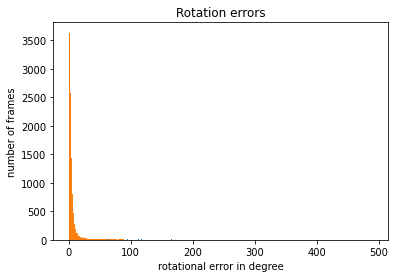

In [16]:
sio.savemat('results.mat', {'trans_pred': np.array(trans_preds), 'trans_gt': np.array(trans_gts), 'uncertainty': np.array(pred_uncertainties)})

if len(pose_map):
    np.savetxt(os.path.join(args.map_dataset, 'map.txt'), np.asarray(pose_map, dtype=np.float32))
    print("map is saved!")

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
plt.savefig('terror.png', bbox_inches='tight')

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
plt.savefig('rerror.png', bbox_inches='tight')

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

# Classification + local GP

In [17]:
trans_errors = []
rot_errors = []
uncertainties = []
pose_map = []

total_trans_error = 0.
total_rot_error = 0.

count = 0.

is_save_map = False
is_read_map = False

trans_preds = []
trans_gts = []

rot_preds = []
rot_gts = []

pred_uncertainties = []

pred_time = []

br = tf_ros.TransformBroadcaster()

GT_POSE_TOPIC = '/gt_pose'
BIRDVIEW_TOPIC_PUB = '/bird_view'
MAP_TOPIC_PUB = '/pose_map'
PARTICLES_PUB = '/particles'
NN_LOCALIZASION_PUB = '/nn_pose'
gt_pose_pub = rospy.Publisher(GT_POSE_TOPIC, Odometry, queue_size=1)
bird_view_pub = rospy.Publisher(BIRDVIEW_TOPIC_PUB, Image, queue_size=1)
map_pub = rospy.Publisher(MAP_TOPIC_PUB, Path, queue_size=1)
particles_pub = rospy.Publisher(PARTICLES_PUB, PoseArray, queue_size=1)
nn_pose_pub = rospy.Publisher(NN_LOCALIZASION_PUB, Odometry, queue_size=1)

trainer.model.eval()

for b, data in enumerate(dataloader, 0):
    start = time.time()
    x,y = data.values()
    trans_pred, rot_pred, trans_gt, rot_gt, samples = trainer.eval_forward(x,y,label_from_gp = True)
    
    # transform data
    trans_pred = trans_pred.cpu().numpy()
    rot_pred = rot_pred.cpu().numpy()
    trans_gt = trans_gt.cpu().numpy()
    rot_gt = rot_gt.cpu().numpy()
    
    end = time.time()
    
    if args.enable_ros:
        particles = PoseArray()
        particles.header.stamp = rospy.Time.now()
        particles.header.frame_id = 'world'
        for s in samples:
            pose = Pose()
            [pose.position.x, pose.position.y, pose.position.z] = s
            [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w] = rot_pred[0]
            particles.poses.append(pose)
        particles_pub.publish(particles)

        [px_pred, py_pred, pz_pred] = trans_pred[0]
        [qx_pred, qy_pred, qz_pred, qw_pred] = rot_pred[0]

        br.sendTransform((px_pred, py_pred, pz_pred),
                         (qx_pred, qy_pred, qz_pred, qw_pred), rospy.Time.now(),
                         "estimation", "world")

        [px_gt, py_gt, pz_gt] = trans_gt[0]
        [qx_gt, qy_gt, qz_gt, qw_gt] = rot_gt[0]

        br.sendTransform((px_gt, py_gt, pz_gt),
                         (qx_gt, qy_gt, qz_gt, qw_gt),
                         rospy.Time.now(), "gt", "world")

        timestamp = rospy.Time.now()

        nn_pose_msg = Odometry()
        nn_pose_msg.header.frame_id = 'world'
        nn_pose_msg.header.stamp = timestamp
        nn_pose_msg.child_frame_id = 'base_link'
        nn_pose_msg.pose.pose.position.x = px_pred
        nn_pose_msg.pose.pose.position.y = py_pred
        nn_pose_msg.pose.pose.position.z = pz_pred
        [nn_pose_msg.pose.pose.orientation.x, nn_pose_msg.pose.pose.orientation.y, nn_pose_msg.pose.pose.orientation.z, nn_pose_msg.pose.pose.orientation.w] = [qx_pred, qy_pred, qz_pred, qw_pred]

        conv = np.zeros((6,6), dtype=np.float32)
        [conv[0][0], conv[1][1], conv[2][2]] = trans_cov[0]
        nn_pose_msg.pose.covariance = conv.flatten().tolist()
        nn_pose_pub.publish(nn_pose_msg)

        bridge = CvBridge()

        bird_view_img_msg = bridge.cv2_to_imgmsg(np.asarray(x[0].cpu(), dtype=np.float32), encoding="passthrough")
        stamp_now = rospy.Time.now()
        bird_view_img_msg.header.stamp = stamp_now

        bird_view_pub.publish(bird_view_img_msg)

        rospy.sleep(.0)
        cv2.waitKey(0)

        count += 1
    else:
        count += y.shape[0]
    
    trans_preds += [x for x in trans_pred]
    rot_preds += [x for x in rot_pred]
    trans_gts += [x for x in trans_gt]
    rot_gts += [x for x in rot_gt]

    trans_error = np.sqrt(np.sum((trans_pred - trans_gt)**2,axis=1))
    rot_error_1 = np.arccos(np.sum(np.multiply(rot_pred,rot_gt),axis=1))/math.pi*180
    rot_error_2 = np.arccos(np.sum(np.multiply(rot_pred,-rot_gt),axis=1))/math.pi*180
    rot_error = np.minimum(rot_error_1,rot_error_2)

    trans_errors += [x for x in trans_error]
    rot_errors += [x for x in rot_error]

    total_trans_error += np.sum(trans_error)
    total_rot_error += np.sum(rot_error)
    
    display = 1

    if b % display == 0:
        print(
            "{}/{}, translation error = {:.3f}, rotation error = {:.3f}, time/batch = {:.3f}"
            .format(
             (b+1)*args.batch_size,
            len(dataloader)*args.batch_size,
            total_trans_error / count,
            total_rot_error / count,
            end - start))

300/92100, translation error = 2.713, rotation error = 2.763, time/batch = 1.593
600/92100, translation error = 6.584, rotation error = 3.388, time/batch = 1.570
900/92100, translation error = 7.289, rotation error = 3.357, time/batch = 1.563
1200/92100, translation error = 6.373, rotation error = 3.423, time/batch = 1.565
1500/92100, translation error = 5.743, rotation error = 3.531, time/batch = 1.564
1800/92100, translation error = 5.088, rotation error = 3.514, time/batch = 1.568
2100/92100, translation error = 4.880, rotation error = 3.635, time/batch = 1.563
2400/92100, translation error = 4.507, rotation error = 3.546, time/batch = 1.569
2700/92100, translation error = 4.314, rotation error = 3.670, time/batch = 1.569
3000/92100, translation error = 4.188, rotation error = 3.689, time/batch = 1.572
3300/92100, translation error = 3.951, rotation error = 3.575, time/batch = 1.580
3600/92100, translation error = 3.894, rotation error = 3.603, time/batch = 1.570
3900/92100, transla

/home/seel/.local/lib/python3.6/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", NumericalWarning)


14400/92100, translation error = 4.206, rotation error = 3.957, time/batch = 1.689
14700/92100, translation error = 4.160, rotation error = 3.926, time/batch = 1.585
15000/92100, translation error = 4.139, rotation error = 3.924, time/batch = 1.589
15300/92100, translation error = 4.112, rotation error = 3.901, time/batch = 1.592
15600/92100, translation error = 4.116, rotation error = 3.962, time/batch = 1.587
15900/92100, translation error = 5.115, rotation error = 4.097, time/batch = 1.590
16200/92100, translation error = 5.076, rotation error = 4.111, time/batch = 1.596
16500/92100, translation error = 5.024, rotation error = 4.088, time/batch = 1.590
16800/92100, translation error = 4.977, rotation error = 4.133, time/batch = 1.588
17100/92100, translation error = 4.927, rotation error = 4.131, time/batch = 1.591
17400/92100, translation error = 4.869, rotation error = 4.111, time/batch = 1.596
17700/92100, translation error = 4.813, rotation error = 4.096, time/batch = 1.593
1800

44100/92100, translation error = 9.032, rotation error = 5.127, time/batch = 1.592
44400/92100, translation error = 9.024, rotation error = 5.144, time/batch = 1.598
44700/92100, translation error = 8.985, rotation error = 5.137, time/batch = 1.600
45000/92100, translation error = 8.941, rotation error = 5.131, time/batch = 1.640
45300/92100, translation error = 8.897, rotation error = 5.132, time/batch = 1.667
45600/92100, translation error = 8.865, rotation error = 5.132, time/batch = 1.603
45900/92100, translation error = 8.818, rotation error = 5.121, time/batch = 1.587
46200/92100, translation error = 8.780, rotation error = 5.123, time/batch = 1.597
46500/92100, translation error = 8.746, rotation error = 5.116, time/batch = 1.595
46800/92100, translation error = 8.710, rotation error = 5.103, time/batch = 1.594
47100/92100, translation error = 8.678, rotation error = 5.098, time/batch = 1.589
47400/92100, translation error = 8.660, rotation error = 5.086, time/batch = 1.599
4770

73800/92100, translation error = 9.463, rotation error = 5.538, time/batch = 1.600
74100/92100, translation error = 9.440, rotation error = 5.535, time/batch = 1.591
74400/92100, translation error = 9.480, rotation error = 5.560, time/batch = 1.606
74700/92100, translation error = 9.686, rotation error = 5.715, time/batch = 1.602
75000/92100, translation error = 9.658, rotation error = 5.711, time/batch = 1.622
75300/92100, translation error = 9.825, rotation error = 5.756, time/batch = 1.651
75600/92100, translation error = 9.841, rotation error = 5.767, time/batch = 1.696
75900/92100, translation error = 9.814, rotation error = 5.758, time/batch = 1.618
76200/92100, translation error = 9.790, rotation error = 5.752, time/batch = 1.589
76500/92100, translation error = 9.762, rotation error = 5.741, time/batch = 1.624
76800/92100, translation error = 9.754, rotation error = 5.739, time/batch = 1.612
77100/92100, translation error = 9.769, rotation error = 5.739, time/batch = 1.607
7740

median translation error = 2.125
median rotation error = 3.168
mean translation error = 11.174
mean rotation error = 6.659


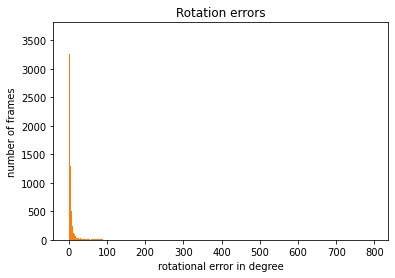

In [18]:
sio.savemat('results.mat', {'trans_pred': np.array(trans_preds), 'trans_gt': np.array(trans_gts), 'uncertainty': np.array(pred_uncertainties)})

if len(pose_map):
    np.savetxt(os.path.join(args.map_dataset, 'map.txt'), np.asarray(pose_map, dtype=np.float32))
    print("map is saved!")

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
plt.savefig('terror.png', bbox_inches='tight')

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
plt.savefig('rerror.png', bbox_inches='tight')

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

# Classification `top-2` + local GP

In [172]:
trans_errors = []
rot_errors = []
uncertainties = []
pose_map = []

total_trans_error = 0.
total_rot_error = 0.

count = 0.

is_save_map = False
is_read_map = False

trans_preds = []
trans_gts = []

rot_preds = []
rot_gts = []

pred_uncertainties = []

pred_time = []

br = tf_ros.TransformBroadcaster()

GT_POSE_TOPIC = '/gt_pose'
BIRDVIEW_TOPIC_PUB = '/bird_view'
MAP_TOPIC_PUB = '/pose_map'
PARTICLES_PUB = '/particles'
NN_LOCALIZASION_PUB = '/nn_pose'
gt_pose_pub = rospy.Publisher(GT_POSE_TOPIC, Odometry, queue_size=1)
bird_view_pub = rospy.Publisher(BIRDVIEW_TOPIC_PUB, Image, queue_size=1)
map_pub = rospy.Publisher(MAP_TOPIC_PUB, Path, queue_size=1)
particles_pub = rospy.Publisher(PARTICLES_PUB, PoseArray, queue_size=1)
nn_pose_pub = rospy.Publisher(NN_LOCALIZASION_PUB, Odometry, queue_size=1)

trainer.model.eval()

for b, data in enumerate(dataloader, 0):
    start = time.time()
    x,y = data.values()
    trans_pred, rot_pred, trans_gt, rot_gt, samples = trainer.eval_forward_top2(x,y)
    
    # transform data
    trans_pred = trans_pred.cpu().numpy()
    rot_pred = rot_pred.cpu().numpy()
    trans_gt = trans_gt.cpu().numpy()
    rot_gt = rot_gt.cpu().numpy()
    
    end = time.time()
    
    if args.enable_ros:
        particles = PoseArray()
        particles.header.stamp = rospy.Time.now()
        particles.header.frame_id = 'world'
        for s in samples:
            pose = Pose()
            [pose.position.x, pose.position.y, pose.position.z] = s
            [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w] = rot_pred[0]
            particles.poses.append(pose)
        particles_pub.publish(particles)

        [px_pred, py_pred, pz_pred] = trans_pred[0]
        [qx_pred, qy_pred, qz_pred, qw_pred] = rot_pred[0]

        br.sendTransform((px_pred, py_pred, pz_pred),
                         (qx_pred, qy_pred, qz_pred, qw_pred), rospy.Time.now(),
                         "estimation", "world")

        [px_gt, py_gt, pz_gt] = trans_gt[0]
        [qx_gt, qy_gt, qz_gt, qw_gt] = rot_gt[0]

        br.sendTransform((px_gt, py_gt, pz_gt),
                         (qx_gt, qy_gt, qz_gt, qw_gt),
                         rospy.Time.now(), "gt", "world")

        timestamp = rospy.Time.now()

        nn_pose_msg = Odometry()
        nn_pose_msg.header.frame_id = 'world'
        nn_pose_msg.header.stamp = timestamp
        nn_pose_msg.child_frame_id = 'base_link'
        nn_pose_msg.pose.pose.position.x = px_pred
        nn_pose_msg.pose.pose.position.y = py_pred
        nn_pose_msg.pose.pose.position.z = pz_pred
        [nn_pose_msg.pose.pose.orientation.x, nn_pose_msg.pose.pose.orientation.y, nn_pose_msg.pose.pose.orientation.z, nn_pose_msg.pose.pose.orientation.w] = [qx_pred, qy_pred, qz_pred, qw_pred]

        conv = np.zeros((6,6), dtype=np.float32)
        [conv[0][0], conv[1][1], conv[2][2]] = trans_cov[0]
        nn_pose_msg.pose.covariance = conv.flatten().tolist()
        nn_pose_pub.publish(nn_pose_msg)

        bridge = CvBridge()

        bird_view_img_msg = bridge.cv2_to_imgmsg(np.asarray(x[0].cpu(), dtype=np.float32), encoding="passthrough")
        stamp_now = rospy.Time.now()
        bird_view_img_msg.header.stamp = stamp_now

        bird_view_pub.publish(bird_view_img_msg)

        rospy.sleep(.0)
        cv2.waitKey(0)

        count += 1
    else:
        count += y.shape[0]
    
    trans_preds += [x for x in trans_pred]
    rot_preds += [x for x in rot_pred]
    trans_gts += [x for x in trans_gt]
    rot_gts += [x for x in rot_gt]

    trans_error = np.sqrt(np.sum((trans_pred - trans_gt)**2,axis=1))
    rot_error_1 = np.arccos(np.sum(np.multiply(rot_pred,rot_gt),axis=1))/math.pi*180
    rot_error_2 = np.arccos(np.sum(np.multiply(rot_pred,-rot_gt),axis=1))/math.pi*180
    rot_error = np.minimum(rot_error_1,rot_error_2)

    trans_errors += [x for x in trans_error]
    rot_errors += [x for x in rot_error]

    total_trans_error += np.sum(trans_error)
    total_rot_error += np.sum(rot_error)
    
    display = 1

    if b % display == 0:
        print(
            "{}/{}, translation error = {:.3f}, rotation error = {:.3f}, time/batch = {:.3f}"
            .format(
             (b+1)*args.batch_size,
            len(dataloader)*args.batch_size,
            total_trans_error / count,
            total_rot_error / count,
            end - start))
    if (b+1)*args.batch_size == 21900:
        break

300/92100, translation error = 2.713, rotation error = 2.763, time/batch = 1.650
600/92100, translation error = 6.571, rotation error = 3.388, time/batch = 1.632
900/92100, translation error = 7.270, rotation error = 3.357, time/batch = 1.630
1200/92100, translation error = 6.358, rotation error = 3.423, time/batch = 1.641
1500/92100, translation error = 5.731, rotation error = 3.531, time/batch = 1.636
1800/92100, translation error = 5.078, rotation error = 3.514, time/batch = 1.631
2100/92100, translation error = 4.872, rotation error = 3.635, time/batch = 1.645
2400/92100, translation error = 4.500, rotation error = 3.546, time/batch = 1.635
2700/92100, translation error = 4.308, rotation error = 3.670, time/batch = 1.642
3000/92100, translation error = 4.183, rotation error = 3.689, time/batch = 1.642
3300/92100, translation error = 3.947, rotation error = 3.575, time/batch = 1.647
3600/92100, translation error = 3.889, rotation error = 3.603, time/batch = 1.646
3900/92100, transla

/home/seel/.local/lib/python3.6/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", NumericalWarning)


14400/92100, translation error = 4.210, rotation error = 3.957, time/batch = 1.696
14700/92100, translation error = 4.164, rotation error = 3.926, time/batch = 1.653
15000/92100, translation error = 4.143, rotation error = 3.924, time/batch = 1.653
15300/92100, translation error = 4.116, rotation error = 3.901, time/batch = 1.661
15600/92100, translation error = 4.123, rotation error = 3.962, time/batch = 1.657
15900/92100, translation error = 5.121, rotation error = 4.097, time/batch = 1.667
16200/92100, translation error = 5.082, rotation error = 4.111, time/batch = 1.655
16500/92100, translation error = 5.030, rotation error = 4.088, time/batch = 1.665
16800/92100, translation error = 4.983, rotation error = 4.133, time/batch = 1.659
17100/92100, translation error = 4.933, rotation error = 4.131, time/batch = 1.662
17400/92100, translation error = 4.875, rotation error = 4.111, time/batch = 1.661
17700/92100, translation error = 4.819, rotation error = 4.096, time/batch = 1.655
1800

median translation error = 2.124
median rotation error = 3.168
mean translation error = 11.172
mean rotation error = 6.659


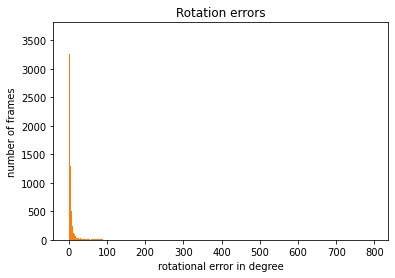

In [160]:
sio.savemat('results.mat', {'trans_pred': np.array(trans_preds), 'trans_gt': np.array(trans_gts), 'uncertainty': np.array(pred_uncertainties)})

if len(pose_map):
    np.savetxt(os.path.join(args.map_dataset, 'map.txt'), np.asarray(pose_map, dtype=np.float32))
    print("map is saved!")

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
plt.savefig('terror.png', bbox_inches='tight')

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
plt.savefig('rerror.png', bbox_inches='tight')

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

In [23]:
def evaluate(trans_errors,rot_errors):
    t = [14301,7008,12852,9567,13580,14835,7114,12683]
    for i in range(len(t)):
        if i >0:
            t[i] += t[i-1]
    trans_errors_month = list()
    trans_errors_month.append(trans_errors[:t[0]])
    trans_errors_month.append(trans_errors[t[0]:t[1]])
    trans_errors_month.append(trans_errors[t[1]:t[2]])
    trans_errors_month.append(trans_errors[t[2]:t[3]])
    trans_errors_month.append(trans_errors[t[3]:t[4]])
    trans_errors_month.append(trans_errors[t[4]:t[5]])
    trans_errors_month.append(trans_errors[t[5]:t[6]])
    trans_errors_month.append(trans_errors[t[6]:])

    rot_errors_month = list()
    rot_errors_month.append(rot_errors[:t[0]])
    rot_errors_month.append(rot_errors[t[0]:t[1]])
    rot_errors_month.append(rot_errors[t[1]:t[2]])
    rot_errors_month.append(rot_errors[t[2]:t[3]])
    rot_errors_month.append(rot_errors[t[3]:t[4]])
    rot_errors_month.append(rot_errors[t[4]:t[5]])
    rot_errors_month.append(rot_errors[t[5]:t[6]])
    rot_errors_month.append(rot_errors[t[6]:])
    
    print('================== var translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("var translation error = {:.3f}".format(np.var(trans_errors_i)))
    
    print('================== median translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("median translation error = {:.3f}".format(np.median(trans_errors_i)))
        
    print('================== median rotation error ==================')
    for rot_errors_i in rot_errors_month:
        print("median rotation error = {:.3f}".format(np.median(rot_errors_i)))
    
    print('================== mean translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("mean translation error = {:.3f}".format(np.mean(trans_errors_i)))
        
    print('================== mean rotation error ==================')  
    for rot_errors_i in rot_errors_month:
        print("mean rotation error = {:.3f}".format(np.mean(rot_errors_i)))
        
evaluate(trans_errors,rot_errors)

================== var translation error ==================
var translation error = 385.414
var translation error = 455.154
var translation error = 2621.602
var translation error = 2642.811
var translation error = 2212.643
var translation error = 3028.174
var translation error = 2256.304
var translation error = 2842.328
================== median translation error ==================
median translation error = 1.711
median translation error = 1.851
median translation error = 2.002
median translation error = 2.076
median translation error = 2.132
median translation error = 2.319
median translation error = 3.547
median translation error = 2.959
================== median rotation error ==================
median rotation error = 2.934
median rotation error = 2.836
median rotation error = 3.045
median rotation error = 2.972
median rotation error = 3.298
median rotation error = 3.246
median rotation error = 4.498
median rotation error = 4.396
================== mean translation error =========